<a href="https://colab.research.google.com/github/Ranjithkrishnasamy/Resub-DS-26/blob/main/Decisiontrees(Fraudcheck).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
path = r"/content/Fraud_check.csv"
data = pd.read_csv(path)

In [3]:
data['Taxable_Income_Category'] = pd.cut(data['Taxable.Income'],
                                         bins=[0, 30000, float('inf')],
                                         labels=['Risky', 'Good'])

In [4]:
data.drop(columns=['Taxable.Income'], inplace=True)

In [5]:
label_encoder = LabelEncoder()
data['Undergrad'] = label_encoder.fit_transform(data['Undergrad'])
data['Marital.Status'] = label_encoder.fit_transform(data['Marital.Status'])
data['Urban'] = label_encoder.fit_transform(data['Urban'])

In [6]:
X = data.drop(['Taxable_Income_Category'], axis=1)
y = data['Taxable_Income_Category']

In [7]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

In [8]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

In [9]:
fold_accuracies = []
fold_roc_auc_scores = []
fold_classification_reports = []

In [10]:
for fold, (train_index, test_index) in enumerate(skf.split(X_resampled_smote, y_resampled_smote)):
    X_train, X_test = X_resampled_smote.iloc[train_index], X_resampled_smote.iloc[test_index]
    y_train, y_test = y_resampled_smote.iloc[train_index], y_resampled_smote.iloc[test_index]

    clf = DecisionTreeClassifier(criterion='gini', random_state=42)

    params = {'max_depth': range(1, 11)}
    grid_search = GridSearchCV(clf, params, cv=StratifiedKFold(n_splits=5))
    grid_search.fit(X_train, y_train)

    pruned_clf = grid_search.best_estimator_

    y_pred = pruned_clf.predict(X_test)
    y_pred_proba = pruned_clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    classification_report_str = classification_report(y_test, y_pred)

    fold_accuracies.append(accuracy)
    fold_roc_auc_scores.append(roc_auc)
    fold_classification_reports.append(classification_report_str)

In [11]:
for fold in range(k_folds):
    print(f"Fold {fold+1} - Accuracy:", fold_accuracies[fold])
    print(f"Fold {fold+1} - ROC AUC Score:", fold_roc_auc_scores[fold])
    print(f"Fold {fold+1} - Classification Report:")
    print(fold_classification_reports[fold])
    print()

Fold 1 - Accuracy: 0.6858638743455497
Fold 1 - ROC AUC Score: 0.6847587719298245
Fold 1 - Classification Report:
              precision    recall  f1-score   support

        Good       0.72      0.60      0.66        96
       Risky       0.66      0.77      0.71        95

    accuracy                           0.69       191
   macro avg       0.69      0.69      0.68       191
weighted avg       0.69      0.69      0.68       191


Fold 2 - Accuracy: 0.6335078534031413
Fold 2 - ROC AUC Score: 0.6657346491228069
Fold 2 - Classification Report:
              precision    recall  f1-score   support

        Good       0.62      0.69      0.65        95
       Risky       0.65      0.57      0.61        96

    accuracy                           0.63       191
   macro avg       0.64      0.63      0.63       191
weighted avg       0.64      0.63      0.63       191


Fold 3 - Accuracy: 0.6894736842105263
Fold 3 - ROC AUC Score: 0.7037673130193906
Fold 3 - Classification Report:
     

In [12]:
best_max_depth = grid_search.best_params_['max_depth']
clf = DecisionTreeClassifier(criterion='gini', max_depth=best_max_depth, random_state=42)
clf.fit(X_resampled_smote, y_resampled_smote)

DecisionTreeClassifier(max_depth=10, random_state=42)

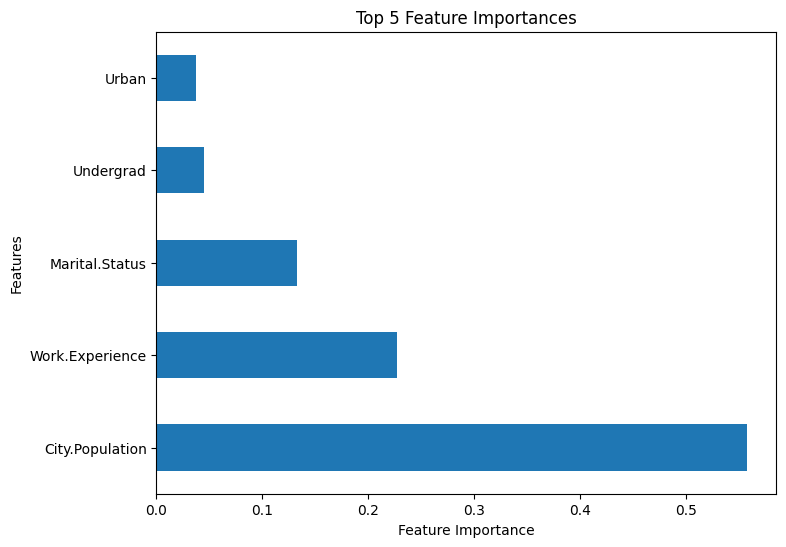

In [14]:
plt.figure(figsize=(8, 6))
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 5 Feature Importances')
plt.show()

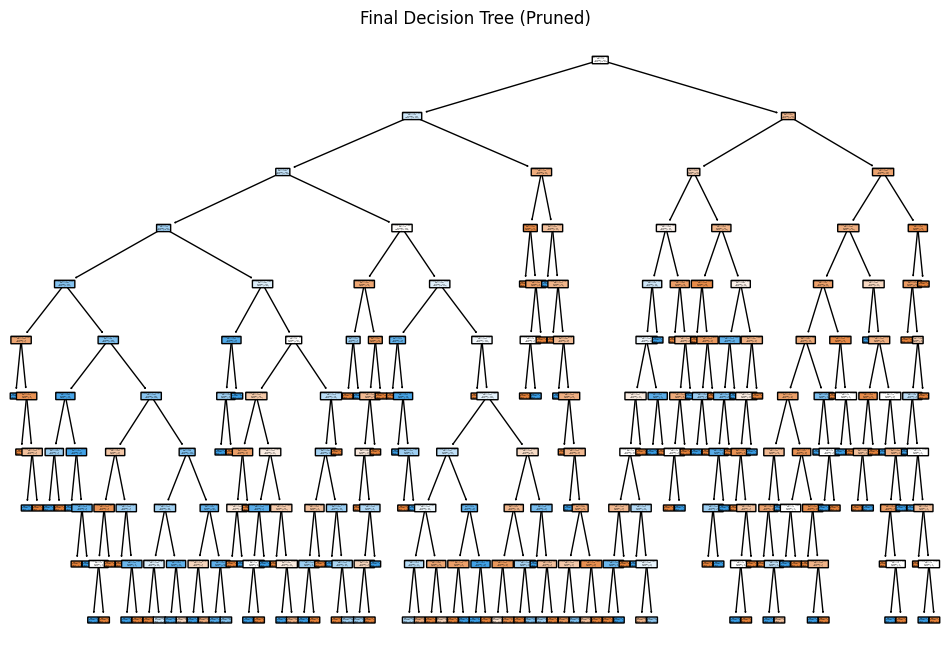

In [15]:
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True)
plt.title("Final Decision Tree (Pruned)")
plt.show()

<ipython-input-16-907fa4ded6ad>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")


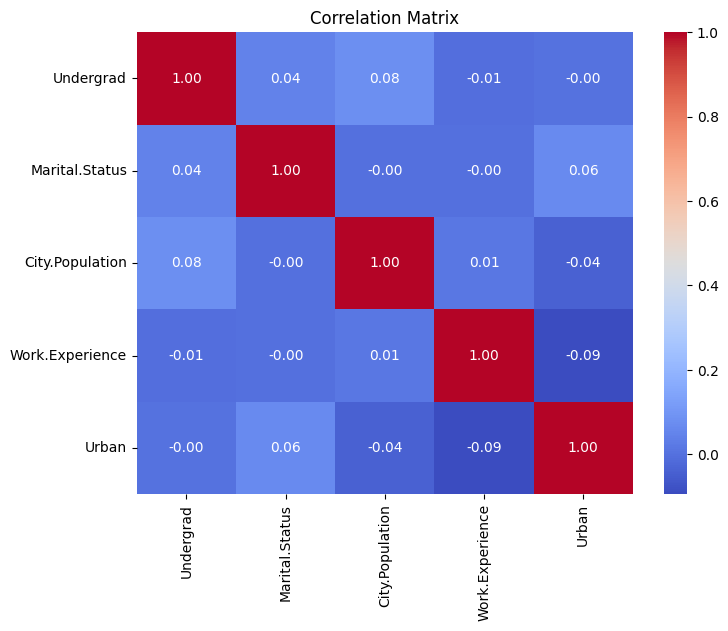

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()